
Bộ dữ liệu có thể được tải xuống từ https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification?resource=download




---



---



In [ ]:
device = "cuda"

# Data acquisition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import cv2
import random
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

In [ ]:
data_dir = '/content/drive/MyDrive/6_classes'

In [ ]:
classes = os.listdir(data_dir)
classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Data preprocessing + EDA

In [ ]:
total_images = 0
for class_ in os.listdir(data_dir):
    count_class = 0
    class_path = os.path.join(data_dir, class_)
    for img in os.listdir(class_path):
        count_class += 1
    total_images += count_class
    print(str(class_) + " has " + str(count_class) + " images.")
print(f"Total number of images: {total_images}")

cardboard has 403 images.
glass has 501 images.
metal has 410 images.
paper has 594 images.
plastic has 482 images.
trash has 137 images.
Total number of images: 2527


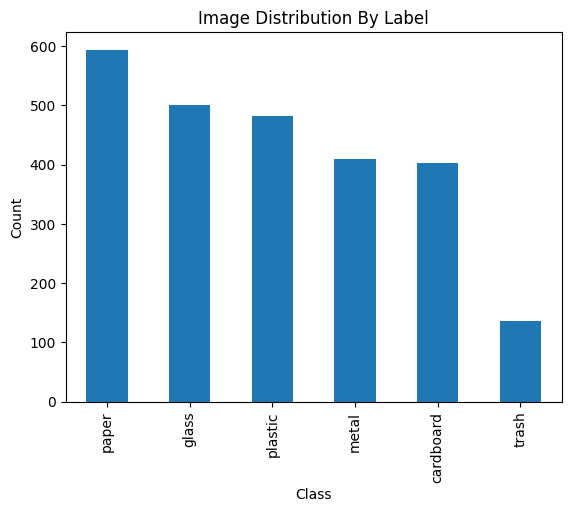

In [ ]:
data = []
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if os.path.isfile(file_path):
                data.append({'path': file_path, 'class_': class_name})

# Tạo DataFrame từ dữ liệu
data_df = pd.DataFrame(data)

# Tính toán số lượng ảnh cho mỗi lớp và vẽ biểu đồ
data_df['class_'].value_counts().plot(kind='bar')
plt.title('Image Distribution By Label')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

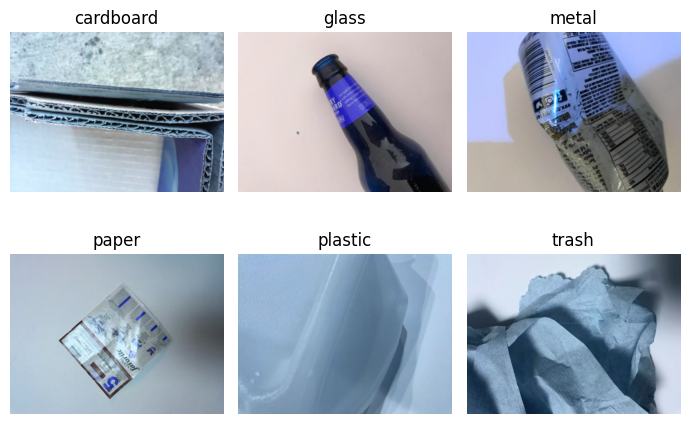

In [ ]:
images = []
for category in classes:
    cls_dir = os.path.join(data_dir, category)
    image_files = os.listdir(cls_dir)
    random_image = random.choice(image_files)
    images.append((category, os.path.join(cls_dir, random_image)))

plt.figure(figsize = (7,7))
for i in range(6):
    plt.subplot(3,3, i+1)
    plt.imshow(cv2.imread(images[i][1]))
    plt.title(images[i][0])
    plt.axis('off')
plt.tight_layout()
plt.show()

Thực hiện một số thay đổi
- Thay đổi kích thước thành 224 x 224
- Biến đổi hình ảnh thành tensor

In [ ]:
transformations = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [ ]:
dataset = ImageFolder(data_dir, transform = transformations)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /content/drive/MyDrive/6_classes
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

# Split Dataset

Để huấn luyện một mô hình, cần chia bộ dữ liệu thành
- Tập train
- Tập validation
- Tập test

In [ ]:
len(dataset)

2527

In [ ]:
train_ratio = int(len(dataset)*0.7)
val_ratio = int(len(dataset)*0.15)+1
test_ratio = int(len(dataset)*0.15)

In [ ]:
train_ratio+val_ratio+test_ratio

2527

In [ ]:
from torch.utils.data import random_split

train_ds, val_ds, test_ds = random_split(dataset, [train_ratio,val_ratio,test_ratio])
len(train_ds), len(val_ds), len(test_ds)

(1768, 380, 379)

# Data Augmentation




In [ ]:
from torch.utils.data import Dataset

class ApplyTransform(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

In [ ]:
torch.manual_seed(42)

from torchvision.transforms.transforms import RandomVerticalFlip
data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(degrees=20),
        transforms.RandomAutocontrast(),
        transforms.RandomGrayscale(),
        transforms.RandomVerticalFlip(0.5)])

In [ ]:
train_ds = ApplyTransform(train_ds, transform=data_transforms)
val_ds = ApplyTransform(val_ds, transform=data_transforms)

In [ ]:
batch_size = 32

Sử dụng DataLoader để tạo batches.

In [ ]:
train_loader = DataLoader(train_ds,
                            batch_size,
                            num_workers = 4,
                            shuffle=True)
val_loader = DataLoader(val_ds,
                         batch_size,
                         num_workers = 4,
                        shuffle=True)

test_loader = DataLoader(test_ds,
                        batch_size,
                        shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

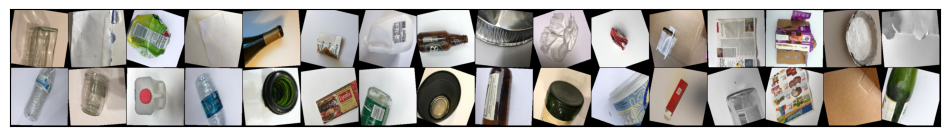

In [ ]:
show_batch(val_loader)

# Fine-Tuning SqueezeNet Model

In [ ]:
def train(model, trainLoader):
    model.to(device)
    model.train()
    train_loss = 0
    train_acc = 0
    for image, label in trainLoader: # lặp qua từng batch trong trainLoader
        image, label = image.to(device), label.to(device)
        output = model(image) # dự đoán đầu ra của ảnh

        loss = loss_fn(output, label) # tính mất mát

        optimizer.zero_grad() # Đặt lại gradient của optimizer
        loss.backward()
        optimizer.step() # Cập nhật trọng số của mô hình

        train_loss += loss.item() # Cộng dồn mất mát
        train_acc += (torch.argmax(output, dim=1) == label).sum().item() # Cộng dồn số lượng dự đoán đúng

    train_loss /= len(trainLoader) # Tính mất mát trung bình trên tất cả các batch
    train_acc /= len(trainLoader.dataset) # Tính độ chính xác trung bình trên toàn bộ tập huấn luyện
    return train_loss, train_acc

In [ ]:
def test(model, testLoader):
    test_loss = 0
    test_acc = 0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for image, label in testLoader:
            image, label = image.to(device), label.to(device)
            output = model(image)

            loss = loss_fn(output, label) # cross entropy loss

            test_loss += loss.item()
            test_acc += (torch.argmax(output, dim=1) == label).sum().item()

    test_loss /= len(testLoader)
    test_acc /= len(testLoader.dataset)
    return test_loss, test_acc

In [ ]:
squeezenet = models.squeezenet1_0(pretrained=True)
squeezenet = squeezenet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 46.2MB/s]


In [ ]:
summary(squeezenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,

In [ ]:
# Điều chỉnh lớp cuối cùng của SqueezeNet
squeezenet.classifier[1] = nn.Conv2d(512, 6, kernel_size=(1, 1), stride=(1, 1)).to(device)

In [ ]:
print(squeezenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
!pip install torchviz

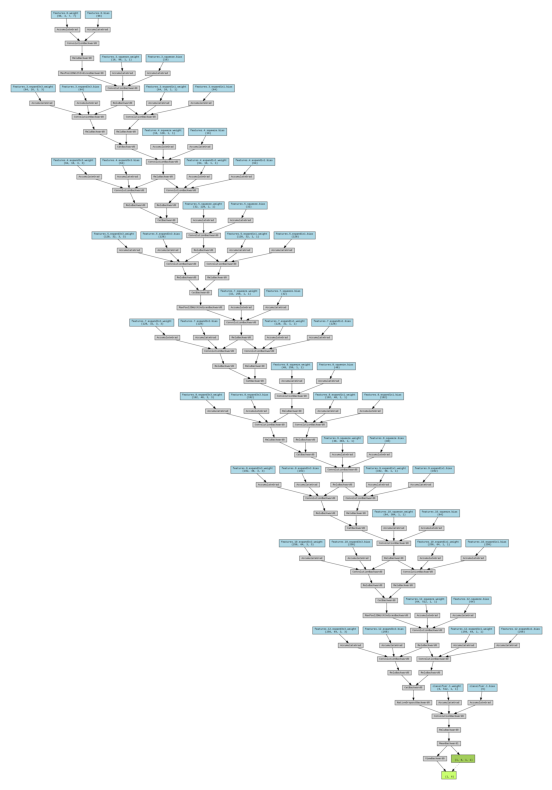

In [ ]:
# Tạo đầu vào giả để truyền qua mô hình và tạo sơ đồ
from torchviz import make_dot
x = torch.randn(1, 3, 224, 224).to(device)
y = squeezenet(x)
# Plot mô hình
dot = make_dot(y, params=dict(squeezenet.named_parameters()))
dot.format = 'png'
dot.render("googlenet_model")

plt.figure(figsize=(10, 10))
img = plt.imread("googlenet_model.png")
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(squeezenet.parameters(), lr=1e-3)

#Training

EPOCH 1
     Train | Loss :  0.9396, Accuracy :  64.82 %
Validation | Loss :  1.6153, Accuracy :  49.87 %
EPOCH 2
     Train | Loss :  0.8740, Accuracy :  68.72 %
Validation | Loss :  0.7913, Accuracy :  70.98 %
EPOCH 3
     Train | Loss :  0.7709, Accuracy :  72.34 %
Validation | Loss :  0.7670, Accuracy :  72.56 %
EPOCH 4
     Train | Loss :  0.7180, Accuracy :  74.60 %
Validation | Loss :  1.1266, Accuracy :  56.99 %
EPOCH 5
     Train | Loss :  0.6781, Accuracy :  75.40 %
Validation | Loss :  0.8857, Accuracy :  68.07 %
EPOCH 6
     Train | Loss :  0.6237, Accuracy :  77.71 %
Validation | Loss :  0.7098, Accuracy :  73.88 %
EPOCH 7
     Train | Loss :  0.5749, Accuracy :  79.52 %
Validation | Loss :  0.7722, Accuracy :  72.30 %
EPOCH 8
     Train | Loss :  0.5761, Accuracy :  79.64 %
Validation | Loss :  0.5955, Accuracy :  78.63 %
EPOCH 9
     Train | Loss :  0.5338, Accuracy :  81.17 %
Validation | Loss :  0.5912, Accuracy :  79.42 %
EPOCH 10
     Train | Loss :  0.5268, Accuracy

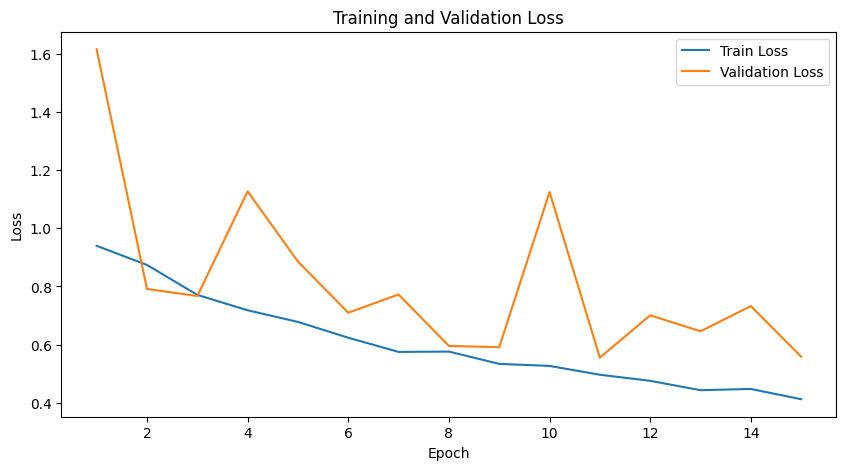

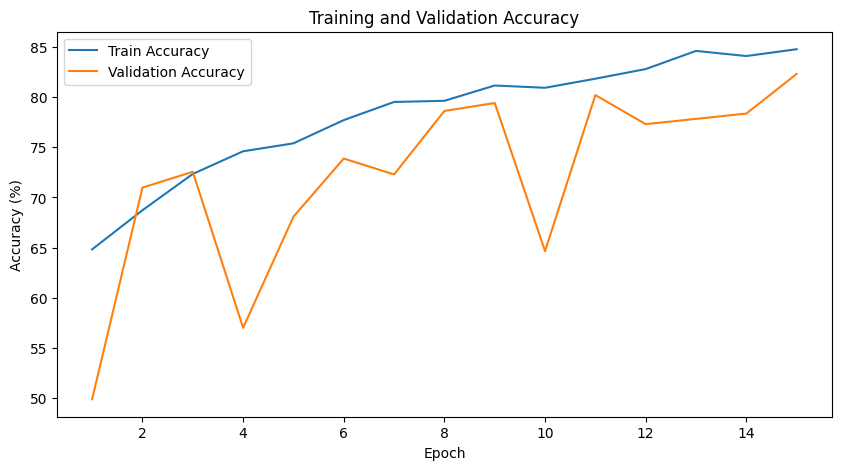

In [ ]:
import time
N_EPOCH = 15
# Lưu các giá trị loss và accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

start_time = time.time()  # Bắt đầu đo thời gian huấn luyện

for epoch in range(1, N_EPOCH + 1):
    print(f'EPOCH {epoch}')

    # Huấn luyện và lưu loss, accuracy của tập huấn luyện
    loss, accuracy = train(squeezenet, train_loader)
    train_losses.append(loss)
    train_accuracies.append(accuracy)

    # Kiểm tra và lưu loss, accuracy của tập kiểm tra
    val_loss, val_accuracy = test(squeezenet, test_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(loss, accuracy * 100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(val_loss, val_accuracy * 100))

end_time = time.time()  # Kết thúc đo thời gian huấn luyện
print(f'Total training time: {end_time - start_time:.2f} seconds')

# Vẽ đồ thị loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Vẽ đồ thị accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), [acc * 100 for acc in train_accuracies], label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), [acc * 100 for acc in val_accuracies], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

EPOCH 1
     Train | Loss :  0.3968, Accuracy :  86.14 %
Validation | Loss :  0.6866, Accuracy :  81.79 %
EPOCH 2
     Train | Loss :  0.4126, Accuracy :  86.03 %
Validation | Loss :  0.5754, Accuracy :  81.53 %
EPOCH 3
     Train | Loss :  0.3815, Accuracy :  86.14 %
Validation | Loss :  0.6709, Accuracy :  78.89 %
Validation loss không giảm, số lần không cải thiện: 1/3
EPOCH 4
     Train | Loss :  0.3716, Accuracy :  87.33 %
Validation | Loss :  0.5512, Accuracy :  83.11 %
EPOCH 5
     Train | Loss :  0.3557, Accuracy :  87.39 %
Validation | Loss :  0.5313, Accuracy :  83.11 %
EPOCH 6
     Train | Loss :  0.3639, Accuracy :  87.05 %
Validation | Loss :  1.2888, Accuracy :  65.44 %
Validation loss không giảm, số lần không cải thiện: 1/3
EPOCH 7
     Train | Loss :  0.3304, Accuracy :  88.69 %
Validation | Loss :  0.5790, Accuracy :  82.59 %
Validation loss không giảm, số lần không cải thiện: 2/3
EPOCH 8
     Train | Loss :  0.3222, Accuracy :  88.46 %
Validation | Loss :  0.6118, Accu

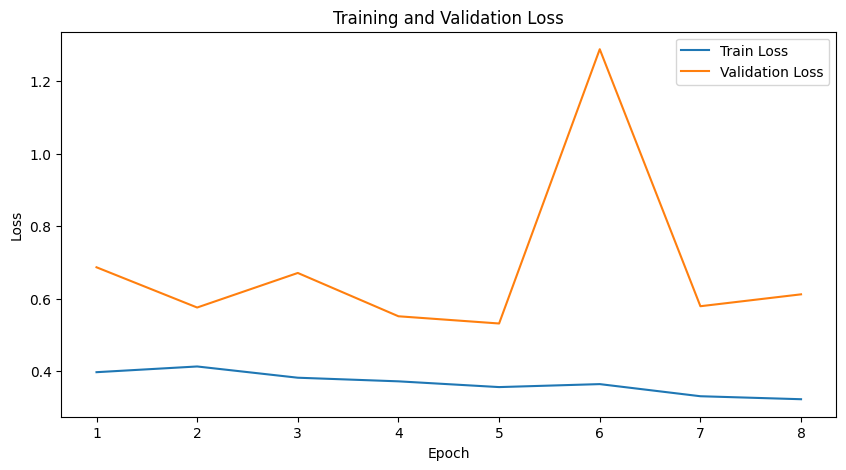

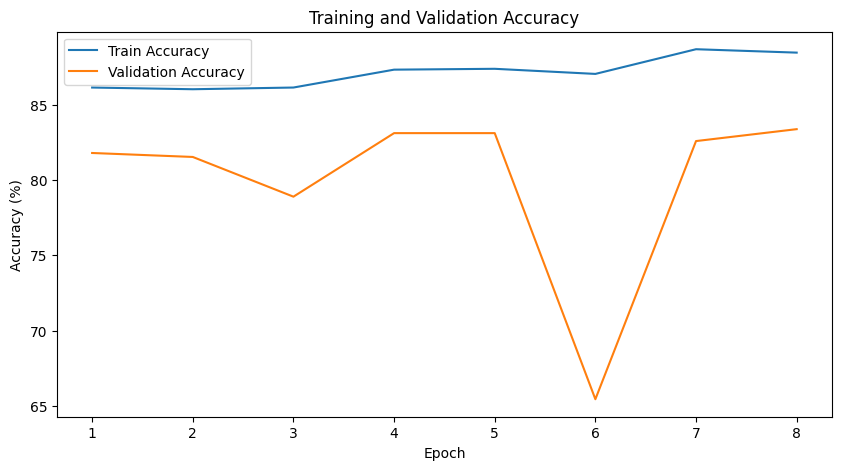

In [ ]:
import time
N_EPOCH = 15
PATIENCE = 3  # Số epoch tối đa không cải thiện trước khi dừng sớm
min_val_loss = float('inf')  # Giá trị loss nhỏ nhất ban đầu
counter = 0  # Biến đếm số epoch không cải thiện

# Lưu các giá trị loss và accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

start_time = time.time()  # Bắt đầu đo thời gian huấn luyện

for epoch in range(1, N_EPOCH + 1):
    print(f'EPOCH {epoch}')

    # Huấn luyện và lưu loss, accuracy của tập huấn luyện
    loss, accuracy = train(squeezenet, train_loader)
    train_losses.append(loss)
    train_accuracies.append(accuracy)

    # Kiểm tra và lưu loss, accuracy của tập kiểm tra
    val_loss, val_accuracy = test(squeezenet, test_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(loss, accuracy * 100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(val_loss, val_accuracy * 100))

    # Kiểm tra điều kiện Early Stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss  # Cập nhật loss tốt nhất
        counter = 0  # Reset bộ đếm
    else:
        counter += 1  # Tăng bộ đếm nếu không cải thiện
        print(f"Validation loss không giảm, số lần không cải thiện: {counter}/{PATIENCE}")

        if counter >= PATIENCE:
            print("Dừng sớm! Không có cải thiện sau {} epoch.".format(PATIENCE))
            break

end_time = time.time()  # Kết thúc đo thời gian huấn luyện
print(f'Total training time: {end_time - start_time:.2f} seconds')

# Vẽ đồ thị loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Vẽ đồ thị accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), [acc * 100 for acc in train_accuracies], label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), [acc * 100 for acc in val_accuracies], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate Model


In [ ]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    # Lấy dự đoán từ mô hình.
    yb = model(xb)
    # Chọn chỉ số có xác suất cao nhất.
    prob, preds  = torch.max(yb, dim=1)
    # Lấy nhãn lớp.
    return dataset.classes[preds[0].item()]

In [ ]:
True_cnt = 0
False_cnt = 0

for i in range(len(test_ds)):
  img, label = test_ds[i]
  if dataset.classes[label] == predict_image(img, squeezenet):
    True_cnt += 1
  else:
    False_cnt += 1

print(f'Mô hình dự đoán đúng {True_cnt} ảnh chính xác')
print(f'Mô hình dự đoán sai  {False_cnt} lần.')

Mô hình dự đoán đúng 316 ảnh chính xác
Mô hình dự đoán sai  63 lần.


In [ ]:
print(f'{round((False_cnt/(False_cnt+True_cnt))*100)}% test set bị dự đoán sai.')

17% test set bị dự đoán sai.


In [ ]:
from collections import Counter
labels = []
for img, label in test_ds:
    labels.append(label)
class_counts = Counter(labels)
for class_label, count in class_counts.items():
    print(f'Lớp {dataset.classes[class_label]} có {count} mẫu.')

Lớp glass có 75 mẫu.
Lớp paper có 95 mẫu.
Lớp metal có 57 mẫu.
Lớp cardboard có 65 mẫu.
Lớp plastic có 67 mẫu.
Lớp trash có 20 mẫu.


In [ ]:
import numpy as np
true_labels = []
predicted_labels = []

for i in range(len(test_ds)):
    img, label = test_ds[i]
    true_labels.append(label)  # Thu thập nhãn thực tế.
    pred_label = predict_image(img, squeezenet)
    predicted_labels.append(pred_label)

In [ ]:
predicted_labels

['glass',
 'paper',
 'glass',
 'paper',
 'paper',
 'glass',
 'metal',
 'paper',
 'glass',
 'plastic',
 'plastic',
 'glass',
 'glass',
 'paper',
 'plastic',
 'glass',
 'glass',
 'glass',
 'cardboard',
 'paper',
 'metal',
 'plastic',
 'paper',
 'metal',
 'plastic',
 'paper',
 'glass',
 'metal',
 'plastic',
 'trash',
 'cardboard',
 'plastic',
 'cardboard',
 'metal',
 'metal',
 'plastic',
 'paper',
 'metal',
 'cardboard',
 'metal',
 'cardboard',
 'paper',
 'paper',
 'paper',
 'metal',
 'paper',
 'trash',
 'plastic',
 'metal',
 'plastic',
 'plastic',
 'plastic',
 'glass',
 'paper',
 'paper',
 'glass',
 'paper',
 'plastic',
 'plastic',
 'cardboard',
 'cardboard',
 'plastic',
 'paper',
 'paper',
 'glass',
 'plastic',
 'plastic',
 'cardboard',
 'paper',
 'metal',
 'plastic',
 'paper',
 'metal',
 'plastic',
 'glass',
 'metal',
 'paper',
 'glass',
 'plastic',
 'cardboard',
 'cardboard',
 'glass',
 'paper',
 'glass',
 'cardboard',
 'cardboard',
 'paper',
 'glass',
 'cardboard',
 'glass',
 'plasti

## Confusion matrix and classification report

              precision    recall  f1-score   support

   cardboard       0.98      0.83      0.90        65
       glass       0.83      0.80      0.82        75
       metal       0.81      0.82      0.82        57
       paper       0.79      0.94      0.86        95
     plastic       0.79      0.88      0.83        67
       trash       1.00      0.35      0.52        20

    accuracy                           0.83       379
   macro avg       0.87      0.77      0.79       379
weighted avg       0.85      0.83      0.83       379



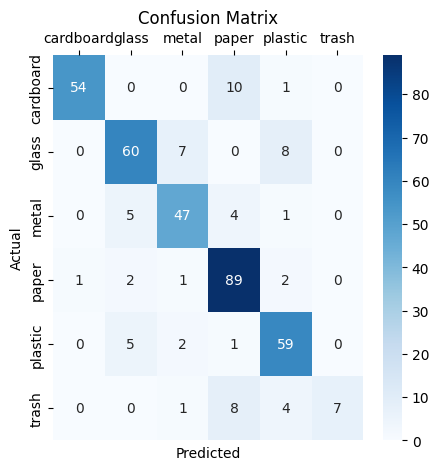

In [ ]:
true_labels = []
predicted_labels = []

for i in range(len(test_ds)):
    img, label = test_ds[i]
    true_labels.append(label)  # Thu thập nhãn thực tế.
    pred_label = predict_image(img, squeezenet)
    predicted_labels.append(pred_label)  # Thu thập nhãn dự đoán.

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

true_labels = np.array([dataset.classes[label] for label in true_labels])

# Tính ma trận nhầm lẫn và báo cáo phân loại.
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=dataset.classes)

print(class_report)

# Vẽ ma trận nhầm lẫn.
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.gca().xaxis.tick_top()
plt.title('Confusion Matrix')
plt.show()


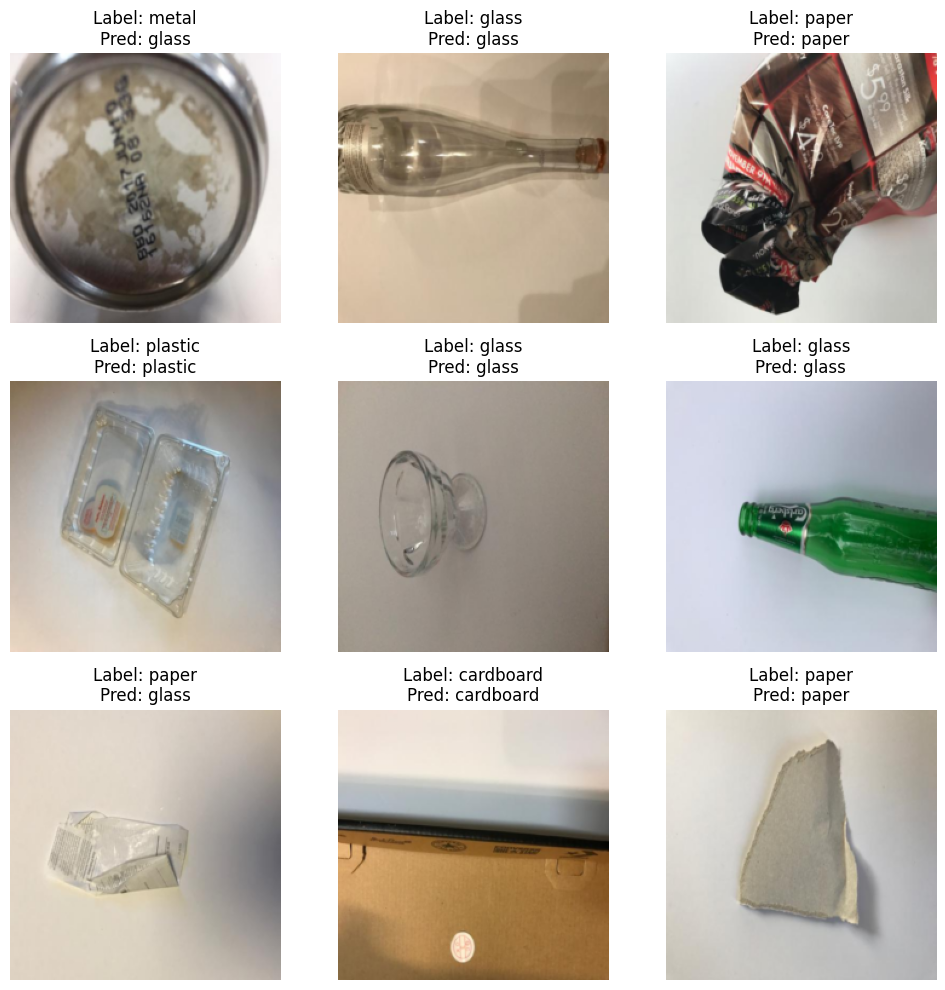

In [ ]:
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,10))

for idx, i in enumerate(range(11, 20)):
    img, label = test_ds[i]
    predicted_class = predict_image(img, squeezenet)

    # Lấy vị trí hàng và cột cho từng ảnh
    row = idx // num_cols
    col = idx % num_cols

    # Hiển thị ảnh và thêm nhãn
    axes[row, col].imshow(img.permute(1, 2, 0))
    axes[row, col].set_title(f'Label: {dataset.classes[label]}\nPred: {predicted_class}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# # test hết ảnh trong test set
# for i in range(len(test_ds)):
#     img, label = test_ds[i]
#     print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, googlenet))
#     plt.imshow(img.permute(1, 2, 0))
#     plt.show()